In [ ]:
!pip install tensorflow

In [ ]:
!pip install xgboost

In [ ]:
!pip install CatBoost

In [ ]:
!pip install lightgbm

In [1]:
#Libraries For Sentiment and Price Comparison
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yf
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import random
from math import sqrt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import LSTM
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
import lightgbm as lgb
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

In [2]:
#Importing Sentiments
sentiment_df = pd.read_csv('C:/Dissertation/Datasets/sumscore2.csv')

In [3]:
# Ripple Price Yahoo Finance 
start_date = '2023-02-28'
end_date = '2023-06-01'
ticker = 'XRP-USD'
yf.pdr_override()
xrp = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)
xrp

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-28,0.379121,0.382433,0.373027,0.377150,0.377150,1000693267
2023-03-01,0.377133,0.384246,0.373666,0.383879,0.383879,912485438
2023-03-02,0.383881,0.384199,0.374483,0.377580,0.377580,812536878
2023-03-03,0.377587,0.379156,0.359894,0.377671,0.377671,1204150691
2023-03-04,0.377671,0.379521,0.370274,0.373813,0.373813,556621575
...,...,...,...,...,...,...
2023-05-27,0.469117,0.477721,0.466716,0.472245,0.472245,634937525
2023-05-28,0.472240,0.485815,0.470784,0.482889,0.482889,570647795
2023-05-29,0.482875,0.494352,0.477904,0.494151,0.494151,1039953786


In [4]:
#Range of XRP Prices and Sentiments
xrp_close_min = xrp['Close'].min()
xrp_close_max = xrp['Close'].max()

print(f'Ripple Close price range: {xrp_close_min} - {xrp_close_max}')

sentiment_min = sentiment_df['FinalScore'].min()
sentiment_max = sentiment_df['FinalScore'].max()

print(f'Sentiment FinalScore range: {sentiment_min} - {sentiment_max}')

Ripple Close price range: 0.36055800318717957 - 0.5435770153999329
Sentiment FinalScore range: -170.3412244 - -32.84220385


In [5]:
sentiment_df

,Unnamed: 0,Date,FinalScore
0,0,27-02-2023,-56.298266
1,1,28-02-2023,-58.008373
2,2,01-03-2023,-77.803071
3,3,02-03-2023,-76.579328
4,4,03-03-2023,-73.377458
...,...,...,...
89,89,27-05-2023,-66.212404
90,90,28-05-2023,-40.889290
91,91,29-05-2023,-44.392002
92,92,30-05-2023,-63.050229


In [6]:
xrp.index = pd.to_datetime(xrp.index)
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'], format='%d-%m-%Y')
sentiment_df

,Unnamed: 0,Date,FinalScore
0,0,2023-02-27,-56.298266
1,1,2023-02-28,-58.008373
2,2,2023-03-01,-77.803071
3,3,2023-03-02,-76.579328
4,4,2023-03-03,-73.377458
...,...,...,...
89,89,2023-05-27,-66.212404
90,90,2023-05-28,-40.889290
91,91,2023-05-29,-44.392002
92,92,2023-05-30,-63.050229


In [7]:
sentiment_df_2 = sentiment_df
sentiment_df_2

,Unnamed: 0,Date,FinalScore
0,0,2023-02-27,-56.298266
1,1,2023-02-28,-58.008373
2,2,2023-03-01,-77.803071
3,3,2023-03-02,-76.579328
4,4,2023-03-03,-73.377458
...,...,...,...
89,89,2023-05-27,-66.212404
90,90,2023-05-28,-40.889290
91,91,2023-05-29,-44.392002
92,92,2023-05-30,-63.050229


In [8]:
merged_df = pd.merge(xrp, sentiment_df, left_index=True, right_on='Date', how='inner')
merged_df

,Open,High,Low,Close,Adj Close,Volume,Unnamed: 0,Date,FinalScore
1,0.379121,0.382433,0.373027,0.377150,0.377150,1000693267,1,2023-02-28,-58.008373
2,0.377133,0.384246,0.373666,0.383879,0.383879,912485438,2,2023-03-01,-77.803071
3,0.383881,0.384199,0.374483,0.377580,0.377580,812536878,3,2023-03-02,-76.579328
4,0.377587,0.379156,0.359894,0.377671,0.377671,1204150691,4,2023-03-03,-73.377458
5,0.377671,0.379521,0.370274,0.373813,0.373813,556621575,5,2023-03-04,-57.974046
...,...,...,...,...,...,...,...,...,...
89,0.469117,0.477721,0.466716,0.472245,0.472245,634937525,89,2023-05-27,-66.212404
90,0.472240,0.485815,0.470784,0.482889,0.482889,570647795,90,2023-05-28,-40.889290
91,0.482875,0.494352,0.477904,0.494151,0.494151,1039953786,91,2023-05-29,-44.392002
92,0.494232,0.525426,0.490547,0.521938,0.521938,2119990185,92,2023-05-30,-63.050229


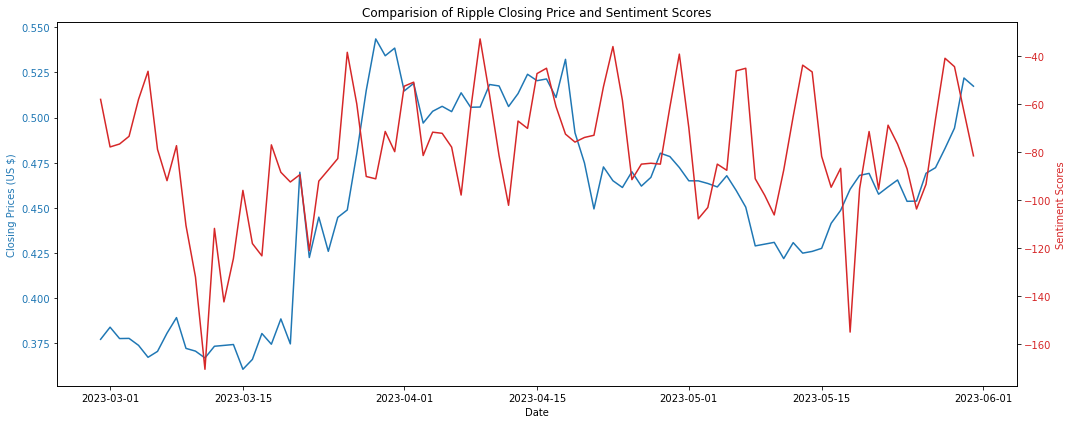

In [9]:
#Time series of Ripple and Sentiments Comparison
fig, ax1 = plt.subplots(figsize=(15, 6))

#Closing prices
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Prices (US $)', color=color)
ax1.plot(merged_df['Date'], merged_df['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()

#Sentiment scores
color = 'tab:red'
ax2.set_ylabel('Sentiment Scores', color=color)
ax2.plot(merged_df['Date'], merged_df['FinalScore'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Comparision of Ripple Closing Price and Sentiment Scores')

fig.tight_layout()
plt.show()

Correlation between XRP Close Prices and Sentiment Scores: 0.3912912604080328
P-value: 0.00010520344799632282


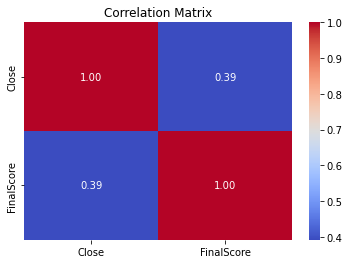

In [10]:
#Correlation - Pearson
merged_df.dropna(inplace=True)

#Correlation matrix
correlation = merged_df[['Close', 'FinalScore']].corr()
correlation_val, p_val = pearsonr(merged_df['Close'], merged_df['FinalScore'])
print("Correlation between XRP Close Prices and Sentiment Scores:", correlation_val)
print("P-value:", p_val)

#Heatmap
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Spearman Correlation between XRP Close Prices and Sentiment Scores: 0.3838739518367103
Spearman P-value: 0.0001455814592345254


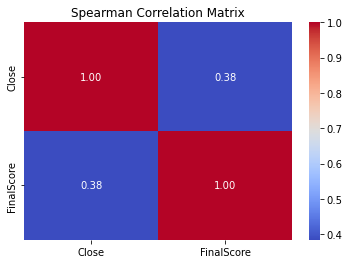

In [11]:
#Correlation - Spearman 
merged_df.dropna(inplace=True)

#Correlation matrix
correlation_spearman, p_val_spearman = spearmanr(merged_df['Close'], merged_df['FinalScore'])

print("Spearman Correlation between XRP Close Prices and Sentiment Scores:", correlation_spearman)
print("Spearman P-value:", p_val_spearman)
correlation_matrix_spearman = merged_df[['Close', 'FinalScore']].corr(method='spearman')

#Heatmap
sns.heatmap(correlation_matrix_spearman, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Spearman Correlation Matrix")
plt.show()

Kendall's tau correlation between XRP Close Prices and Sentiment Scores: 0.2622720897615708
Kendall's tau p-value: 0.00019630850293027503


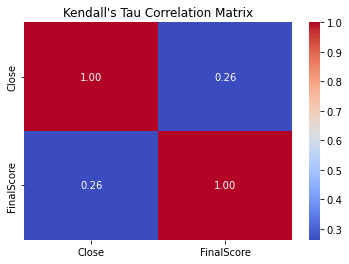

In [12]:
#Correlation - Kendall's Tau
merged_df.dropna(inplace=True)

#Correlation matrix
correlation_kendall = merged_df[['Close', 'FinalScore']].corr(method='kendall')
correlation_val_kendall, p_val_kendall = kendalltau(merged_df['Close'], merged_df['FinalScore'])

print("Kendall's tau correlation between XRP Close Prices and Sentiment Scores:", correlation_val_kendall)
print("Kendall's tau p-value:", p_val_kendall)

#Heatmap
sns.heatmap(correlation_kendall, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Kendall's Tau Correlation Matrix")
plt.show()


In [13]:
#Granger causality test
gc_res = grangercausalitytests(merged_df[['Close', 'FinalScore']], maxlag=1, verbose=False)

p_value_price_sentiment = gc_res[1][0]['ssr_ftest'][1]
p_value_sentiment_price = gc_res[1][0]['ssr_chi2test'][1]

print('P-value of XRP Close Prices causing Sentiment Score:', p_value_price_sentiment)
if p_value_price_sentiment <= 0.05:
    print("Strong evidence against the null hypothesis, reject the null hypothesis. There is a Granger causality from XRP Close Prices to Sentiment Scores.")
else:
    print("Weak evidence against the null hypothesis, fail to reject the null hypothesis. There is no Granger causality from XRP Close Prices to Sentiment Scores.")

print('P-value of Sentiment Score causing XRP Close Prices:', p_value_sentiment_price)
if p_value_sentiment_price <= 0.05:
    print("Strong evidence against the null hypothesis, reject the null hypothesis. There is a Granger causality from Sentiment Scores to XRP Close Prices.")
else:
    print("Weak evidence against the null hypothesis, fail to reject the null hypothesis. There is no Granger causality from Sentiment Scores to XRP Close Prices.")

P-value of XRP Close Prices causing Sentiment Score: 0.6826996287920548
Weak evidence against the null hypothesis, fail to reject the null hypothesis. There is no Granger causality from XRP Close Prices to Sentiment Scores.
P-value of Sentiment Score causing XRP Close Prices: 0.6766928789257378
Weak evidence against the null hypothesis, fail to reject the null hypothesis. There is no Granger causality from Sentiment Scores to XRP Close Prices.


In [14]:
#Checking Correlation of Sentiments by lag
sentiment_df= sentiment_df[(sentiment_df['Date'] >='2023-02-28')&(sentiment_df['Date'] <='2023-05-31')]

#Range of lags
min_lag = 1
max_lag = 20

#Correlations
correlations = []
for lag in range(min_lag, max_lag + 1):
    lagged_sentiment_scores = sentiment_df['FinalScore'][:-lag]
    lagged_closing_prices = xrp['Close'][lag:]

    correlation, _ = pearsonr(lagged_closing_prices, lagged_sentiment_scores)
    correlations.append(correlation)

for lag, correlation in zip(range(min_lag, max_lag + 1), correlations):
    print(f"Correlation for lag {lag}: {correlation}")

Correlation for lag 1: 0.38724098736824325
Correlation for lag 2: 0.39098534523745726
Correlation for lag 3: 0.3876475415497999
Correlation for lag 4: 0.3203824220279809
Correlation for lag 5: 0.2952981597842836
Correlation for lag 6: 0.26709663382223864
Correlation for lag 7: 0.21777942131834135
Correlation for lag 8: 0.14729177643226318
Correlation for lag 9: 0.13421713229585258
Correlation for lag 10: 0.013566478849741439
Correlation for lag 11: -0.039205525695208854
Correlation for lag 12: -0.09414899865313837
Correlation for lag 13: -0.09014719604383803
Correlation for lag 14: -0.1382140921255136
Correlation for lag 15: -0.20755786004373697
Correlation for lag 16: -0.24406899059602608
Correlation for lag 17: -0.30733443713440317
Correlation for lag 18: -0.4123131994220953
Correlation for lag 19: -0.46431979309116506
Correlation for lag 20: -0.5139100559216602


In [15]:
#Preparing Train and Test Data
sentiment_df_2= sentiment_df_2[(sentiment_df_2['Date'] >='2023-02-27')&(sentiment_df_2['Date'] <='2023-05-31')]
sentiment_df_2 = sentiment_df_2.drop('Unnamed: 0', axis=1)
sentiment_df_2

,Date,FinalScore
0,2023-02-27,-56.298266
1,2023-02-28,-58.008373
2,2023-03-01,-77.803071
3,2023-03-02,-76.579328
4,2023-03-03,-73.377458
...,...,...
89,2023-05-27,-66.212404
90,2023-05-28,-40.889290
91,2023-05-29,-44.392002
92,2023-05-30,-63.050229


In [16]:
sentiment_df_2['Lagged_score'] = sentiment_df_2['FinalScore'].shift(2)
sentiment_df_2 = sentiment_df_2.drop(sentiment_df_2.index[0])
sentiment_df_2= sentiment_df_2.reset_index()
sentiment_df_2 = sentiment_df_2.drop('index', axis=1)
sentiment_df_2

,Date,FinalScore,Lagged_score
0,2023-02-28,-58.008373,NaN
1,2023-03-01,-77.803071,-56.298266
2,2023-03-02,-76.579328,-58.008373
3,2023-03-03,-73.377458,-77.803071
4,2023-03-04,-57.974046,-76.579328
...,...,...,...
88,2023-05-27,-66.212404,-103.629065
89,2023-05-28,-40.889290,-93.328212
90,2023-05-29,-44.392002,-66.212404
91,2023-05-30,-63.050229,-40.889290


In [17]:
# Merging the extracted columns into a new dataframe
merged_df_2 = pd.merge(xrp, sentiment_df_2, left_index=True, right_on='Date', how='inner')
merged_df_2

,Open,High,Low,Close,Adj Close,Volume,Date,FinalScore,Lagged_score
0,0.379121,0.382433,0.373027,0.377150,0.377150,1000693267,2023-02-28,-58.008373,NaN
1,0.377133,0.384246,0.373666,0.383879,0.383879,912485438,2023-03-01,-77.803071,-56.298266
2,0.383881,0.384199,0.374483,0.377580,0.377580,812536878,2023-03-02,-76.579328,-58.008373
3,0.377587,0.379156,0.359894,0.377671,0.377671,1204150691,2023-03-03,-73.377458,-77.803071
4,0.377671,0.379521,0.370274,0.373813,0.373813,556621575,2023-03-04,-57.974046,-76.579328
...,...,...,...,...,...,...,...,...,...
88,0.469117,0.477721,0.466716,0.472245,0.472245,634937525,2023-05-27,-66.212404,-103.629065
89,0.472240,0.485815,0.470784,0.482889,0.482889,570647795,2023-05-28,-40.889290,-93.328212
90,0.482875,0.494352,0.477904,0.494151,0.494151,1039953786,2023-05-29,-44.392002,-66.212404
91,0.494232,0.525426,0.490547,0.521938,0.521938,2119990185,2023-05-30,-63.050229,-40.889290


In [18]:
#Extracting Relevant Columns
merged_df_2= merged_df_2[['Date','Close','Lagged_score','FinalScore']]
merged_df_2

,Date,Close,Lagged_score,FinalScore
0,2023-02-28,0.377150,NaN,-58.008373
1,2023-03-01,0.383879,-56.298266,-77.803071
2,2023-03-02,0.377580,-58.008373,-76.579328
3,2023-03-03,0.377671,-77.803071,-73.377458
4,2023-03-04,0.373813,-76.579328,-57.974046
...,...,...,...,...
88,2023-05-27,0.472245,-103.629065,-66.212404
89,2023-05-28,0.482889,-93.328212,-40.889290
90,2023-05-29,0.494151,-66.212404,-44.392002
91,2023-05-30,0.521938,-40.889290,-63.050229


In [19]:
#Fitting Models
def calculate_mape(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return "{:.2f}%".format(mape)

In [20]:
#XGBoost with Hyperparameter Tuning

#One day lagged
merged_df_2['Lagged_closing_price'] = merged_df_2['Close'].shift(1)
merged_df_2 = merged_df_2.dropna()

#Features
X = merged_df_2[['Lagged_score', 'Lagged_closing_price']]
y = merged_df_2['Close']

train_size = int(0.8 * len(merged_df_2)) 
X_train= X[:train_size]
X_test= X[train_size:]
y_train= y[:train_size]
y_test= y[train_size:]

#hyperparameters to be tuned
param_dist = {
    'n_estimators': [10, 30, 50, 100, 150, 200, 300, 500],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 12],
    'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.5, 1],
    'min_child_weight': [1, 2, 3, 4, 5, 6]
}

xgb_reg = xgb.XGBRegressor(seed=12)
random_search = RandomizedSearchCV(xgb_reg, param_distributions=param_dist, n_iter=100,
                                   scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1, random_state=42)


#Fit the model
random_search.fit(X_train, y_train)

#Finding the best estimator and predict on the test set
best_xgb_reg = random_search.best_estimator_

y_pred = best_xgb_reg.predict(X_test)

#Evaluation metrics
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape_test = calculate_mape(y_test, y_pred)
print(f'Best Parameters: {random_search.best_params_}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error: {mape_test}')

C:\Users\felix\AppData\Local\Temp\ipykernel_24392\3120596969.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_2['Lagged_closing_price'] = merged_df_2['Close'].shift(1)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.25, 'gamma': 0, 'colsample_bytree': 1.0}
Root Mean Squared Error: 0.01925479856008343
Mean Absolute Error: 0.014652374543641744
Mean Absolute Percentage Error: 3.15%


In [21]:

X_test['Date'] = merged_df_2['Date'].iloc[len(y_train):].values
XGB_result_df = pd.DataFrame({'Date': X_test['Date'].values, 'Close': y_test.values, 'Predicted_Ripple_Price': y_pred})

#Adding new columns for the direction of the actual and predicted prices
XGB_result_df['Actual_Direction'] = np.where(XGB_result_df['Close'] > XGB_result_df['Close'].shift(1), 'Up', 'Down')
XGB_result_df['Predicted_Direction'] = np.where(XGB_result_df['Predicted_Ripple_Price'] > XGB_result_df['Predicted_Ripple_Price'].shift(1), 'Up', 'Down')
print(XGB_result_df.head())

#Comparing 'Actual_Direction' and 'Predicted_Direction' columns
matches = XGB_result_df['Actual_Direction'] == XGB_result_df['Predicted_Direction']
accuracy = (matches.sum() / len(matches)) * 100
print(f'Accuracy: {accuracy}%')

        Date     Close  Predicted_Ripple_Price Actual_Direction  \
0 2023-05-13  0.424903                0.445399             Down   
1 2023-05-14  0.425860                0.440316               Up   
2 2023-05-15  0.427562                0.432252               Up   
3 2023-05-16  0.441422                0.430122               Up   
4 2023-05-17  0.448589                0.450842               Up   

  Predicted_Direction  
0                Down  
1                Down  
2                Down  
3                Down  
4                  Up  
Accuracy: 47.368421052631575%


C:\Users\felix\AppData\Local\Temp\ipykernel_24392\2871058584.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Date'] = merged_df_2['Date'].iloc[len(y_train):].values


In [22]:
XGB_result_df.to_csv("C:/Dissertation/ML Codes Final/ML Output/xrp_XGB.csv")

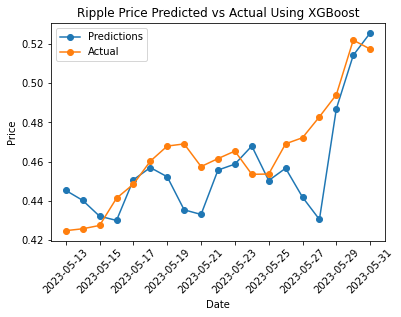

In [23]:

predictions = XGB_result_df['Predicted_Ripple_Price']
actual_values = XGB_result_df['Close']

# Plotting the line graph
plt.plot(XGB_result_df['Date'], predictions, marker='o', label='Predictions')
plt.plot(XGB_result_df['Date'], actual_values, marker='o', label='Actual')

plt.title('Ripple Price Predicted vs Actual Using XGBoost')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)

plt.legend()

# Displaying the plot
plt.show()

In [24]:
#Gated Reccurrent Unit

np.random.seed(44)
tf.random.set_seed(44)
random.seed(44)

# Scaling the input features
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(merged_df_2[['Lagged_score', 'Lagged_closing_price']])
target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(merged_df_2[['Close']])

X = X_scaled
y = y_scaled

#Splitting the dataset into the Training set and Test set sequentially
split_ratio = 0.8
split_idx = int(split_ratio * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

#Building the GRU model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(units=50))
model.add(Dense(1))

#Compiling the GRU
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=50, batch_size=64)

y_pred = model.predict(X_test)

y_test_original = target_scaler.inverse_transform(y_test)
y_pred_original = target_scaler.inverse_transform(y_pred)

rmse = sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)
mape_test = calculate_mape(y_test, y_pred)
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error: {mape_test}')

Epoch 1/50
2/2 [==============================] - 3s 18ms/step - loss: 0.3123
Epoch 2/50
2/2 [==============================] - 0s 6ms/step - loss: 0.2692
Epoch 3/50
2/2 [==============================] - 0s 5ms/step - loss: 0.2300
Epoch 4/50
2/2 [==============================] - 0s 1ms/step - loss: 0.1942
Epoch 5/50
2/2 [==============================] - 0s 6ms/step - loss: 0.1620
Epoch 6/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1336
Epoch 7/50
2/2 [==============================] - 0s 8ms/step - loss: 0.1093
Epoch 8/50
2/2 [==============================] - 0s 3ms/step - loss: 0.0883
Epoch 9/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0738
Epoch 10/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0622
Epoch 11/50
2/2 [==============================] - 0s 4ms/step - loss: 0.0564
Epoch 12/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0554
Epoch 13/50
2/2 [==============================] - 0s 9ms/step - loss: 0

In [25]:
y_test = pd.DataFrame(y_test_original, columns=['Values'])
y_pred= pd.DataFrame(y_pred_original, columns=['Values'])

In [26]:
GRU_result_df = pd.DataFrame({'Date':merged_df_2['Date'].iloc[len(y_train):].values , 'Close': y_test['Values'].values, 'Predicted_Ripple_Price': y_pred['Values'].values})

GRU_result_df['Actual_Direction'] = np.where(GRU_result_df['Close'] > GRU_result_df['Close'].shift(1), 'Up', 'Down')
GRU_result_df['Predicted_Direction'] = np.where(GRU_result_df['Predicted_Ripple_Price'] > GRU_result_df['Predicted_Ripple_Price'].shift(1), 'Up', 'Down')
print(GRU_result_df.head())

matches_test = GRU_result_df['Actual_Direction'] == GRU_result_df['Predicted_Direction']
accuracy_test = (matches_test.sum() / len(matches_test)) * 100
print(f'Accuracy for Test Data: {accuracy_test}%')

        Date     Close  Predicted_Ripple_Price Actual_Direction  \
0 2023-05-13  0.424903                0.433215             Down   
1 2023-05-14  0.425860                0.431812               Up   
2 2023-05-15  0.427562                0.435385               Up   
3 2023-05-16  0.441422                0.436335               Up   
4 2023-05-17  0.448589                0.442293               Up   

  Predicted_Direction  
0                Down  
1                Down  
2                  Up  
3                  Up  
4                  Up  
Accuracy for Test Data: 52.63157894736842%


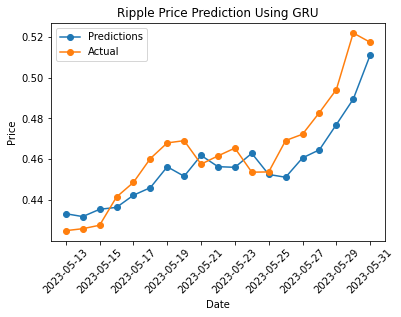

In [27]:
predictions = GRU_result_df['Predicted_Ripple_Price']
actual_values = GRU_result_df['Close']

plt.plot(GRU_result_df['Date'], predictions, marker='o', label='Predictions')
plt.plot(GRU_result_df['Date'], actual_values, marker='o', label='Actual')


plt.title('Ripple Price Prediction Using GRU')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)

plt.legend()

plt.show()

In [28]:
#Holt's Winter
np.random.seed(0)
X = merged_df_2[['Lagged_score', 'Lagged_closing_price']]
y = merged_df_2['Close']

# Splitting the dataset into the Training set and Test set sequentially
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define a list of seasonal periods to try
seasonal_periods = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30] 

best_model = None
best_rmse = float('inf')

# Perform grid search
for period in seasonal_periods:
    model = ExponentialSmoothing(y_train, seasonal='add', seasonal_periods=period)
    model_fit = model.fit()

    y_pred = model_fit.predict(start=X_test.index[0], end=X_test.index[-1])

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model_fit
        best_seasonal_period = period

# Print the best seasonal period and RMSE
print("Best Seasonal Period:", best_seasonal_period)
print("Best RMSE:", best_rmse)


C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index

Best Seasonal Period: 30
Best RMSE: 0.031531069712842176


C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index i

In [29]:
#Holtz Winter
np.random.seed(0)
X = merged_df_2[['Lagged_score', 'Lagged_closing_price']]
y = merged_df_2['Close']

#Splitting the dataset into the Training set and Test set sequentially
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#Fit the Holt's Winters model
model = ExponentialSmoothing(y_train, seasonal='add', seasonal_periods=8)
model_fit = model.fit()


y_pred = model_fit.forecast(len(y_test))

#Evaluation metrics
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape_test = calculate_mape(y_test, y_pred)
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error: {mape_test}')

Root Mean Squared Error: 0.04571371640850792
Mean Absolute Error: 0.036789084318952656
Mean Absolute Percentage Error: 7.27%


C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [30]:

HW_result_df = pd.DataFrame({
    'Date': merged_df_2['Date'].iloc[len(y_train):],
    'Close': y_test.values,
    'Predicted_Ripple_Price': y_pred.values
})

HW_result_df['Actual_Direction'] = np.where(HW_result_df['Close'] > HW_result_df['Close'].shift(1), 'Up', 'Down')
HW_result_df['Predicted_Direction'] = np.where(HW_result_df['Predicted_Ripple_Price'] > HW_result_df['Predicted_Ripple_Price'].shift(1), 'Up', 'Down')

print(HW_result_df)


matches = HW_result_df['Actual_Direction'] == HW_result_df['Predicted_Direction']

accuracy = (matches.sum() / len(matches)) * 100
print(f'Accuracy for Test Data: {accuracy}%')

         Date     Close  Predicted_Ripple_Price Actual_Direction  \
74 2023-05-13  0.424903                0.422550             Down   
75 2023-05-14  0.425860                0.424726               Up   
76 2023-05-15  0.427562                0.423856               Up   
77 2023-05-16  0.441422                0.436625               Up   
78 2023-05-17  0.448589                0.429328               Up   
79 2023-05-18  0.460299                0.430288               Up   
80 2023-05-19  0.467982                0.425069               Up   
81 2023-05-20  0.469081                0.430180               Up   
82 2023-05-21  0.457550                0.422550             Down   
83 2023-05-22  0.461601                0.424726               Up   
84 2023-05-23  0.465430                0.423856               Up   
85 2023-05-24  0.453609                0.436625             Down   
86 2023-05-25  0.453734                0.429328               Up   
87 2023-05-26  0.469140                0.430288 

In [31]:
HW_result_df.to_csv("C:/Dissertation/ML Codes Final/ML Output/xrp_hw.csv")

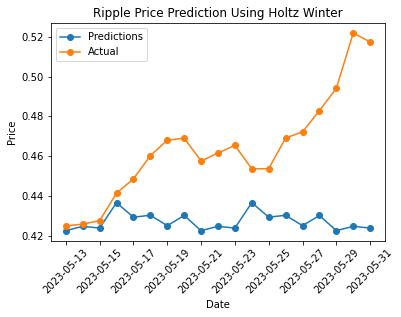

In [32]:
predictions = HW_result_df['Predicted_Ripple_Price']
actual_values = HW_result_df['Close']

plt.plot(HW_result_df['Date'], predictions, marker='o', label='Predictions')
plt.plot(HW_result_df['Date'], actual_values, marker='o', label='Actual')

plt.title('Ripple Price Prediction Using Holtz Winter')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)

plt.legend()

plt.show()

In [36]:
#SVR- Support Vector Regression

X = merged_df_2[['Lagged_closing_price', 'Lagged_score']].values
y = merged_df_2['Close'].values.reshape(-1, 1)

scaler_X = MinMaxScaler(feature_range=(0, 1))
X = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = SVR(kernel='rbf', C=1e2, gamma=0.1)

#Fit the model
model.fit(X_train, y_train.ravel())

train_predict = model.predict(X_train).reshape(-1, 1)
test_predict = model.predict(X_test).reshape(-1, 1)

train_predict = scaler_y.inverse_transform(train_predict)
y_train = scaler_y.inverse_transform(y_train)
test_predict = scaler_y.inverse_transform(test_predict)
y_test = scaler_y.inverse_transform(y_test)

#Evaluation metrics
rmse_train = sqrt(mean_squared_error(y_train, train_predict))
mae_train = mean_absolute_error(y_train, train_predict)
rmse_test = sqrt(mean_squared_error(y_test, test_predict))
mae_test = mean_absolute_error(y_test, test_predict)
mape_test = calculate_mape(y_test, test_predict)
print(f'Root Mean Squared Error: {rmse_test}')
print(f'Mean Absolute Error: {mae_test}')
print(f'Mean Absolute Percentage Error: {mape_test}')

Root Mean Squared Error: 0.009344466836881312
Mean Absolute Error: 0.007921180540099998
Mean Absolute Percentage Error: 1.70%


In [37]:
SVR_result_df = pd.DataFrame({
    'Date': merged_df_2['Date'].iloc[len(y_train):].values,
    'Close': y_test.flatten(),
    'Predicted_Ripple_Price': test_predict.flatten()
})

# Adding new columns for the direction of the actual and predicted prices
SVR_result_df['Actual_Direction'] = np.where(SVR_result_df['Close'] > SVR_result_df['Close'].shift(1), 'Up', 'Down')
SVR_result_df['Predicted_Direction'] = np.where(SVR_result_df['Predicted_Ripple_Price'] > SVR_result_df['Predicted_Ripple_Price'].shift(1), 'Up', 'Down')

print(SVR_result_df.head())

# Compare 'Actual_Direction' and 'Predicted_Direction' columns
matches = SVR_result_df['Actual_Direction'] == SVR_result_df['Predicted_Direction']
accuracy = (matches.sum() / len(matches)) * 100
print(f'Accuracy: {accuracy}%')

        Date     Close  Predicted_Ripple_Price Actual_Direction  \
0 2023-05-13  0.424903                0.434375             Down   
1 2023-05-14  0.425860                0.431785               Up   
2 2023-05-15  0.427562                0.436364               Up   
3 2023-05-16  0.441422                0.437553               Up   
4 2023-05-17  0.448589                0.445539               Up   

  Predicted_Direction  
0                Down  
1                Down  
2                  Up  
3                  Up  
4                  Up  
Accuracy: 57.89473684210527%


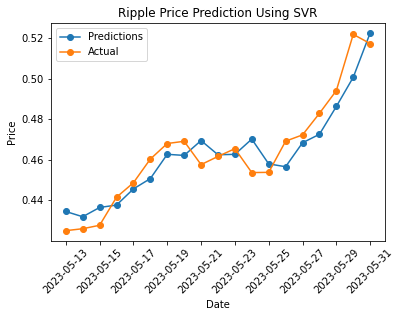

In [38]:
predictions = SVR_result_df['Predicted_Ripple_Price']
actual_values = SVR_result_df['Close']

# Plotting the line graph
plt.plot(SVR_result_df['Date'], predictions, marker='o', label='Predictions')
plt.plot(SVR_result_df['Date'], actual_values, marker='o', label='Actual')

plt.title('Ripple Price Prediction Using SVR')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)

plt.legend()

plt.show()

In [39]:
SVR_result_df.to_csv("C:/Dissertation/ML Codes Final/ML Output/xrp_SVR.csv")

In [40]:
#LightGBM

#Features
X = merged_df_2[['Lagged_closing_price', 'Lagged_score']].values
y = merged_df_2['Close'].values.reshape(-1, 1)

#Scaling
scaler_X = MinMaxScaler(feature_range=(0, 1))
X = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler_y.fit_transform(y)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#Building LightGBM Model
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

lgb_train = lgb.Dataset(X_train, y_train.ravel())
lgb_eval = lgb.Dataset(X_test, y_test.ravel(), reference=lgb_train)

model = lgb.train(params, lgb_train, num_boost_round=1000, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=200)

train_predict = model.predict(X_train, num_iteration=model.best_iteration).reshape(-1, 1)
test_predict = model.predict(X_test, num_iteration=model.best_iteration).reshape(-1, 1)

train_predict = scaler_y.inverse_transform(train_predict)
y_train = scaler_y.inverse_transform(y_train)
test_predict = scaler_y.inverse_transform(test_predict)
y_test = scaler_y.inverse_transform(y_test)

#Evaluation metrics
rmse_train = sqrt(mean_squared_error(y_train, train_predict))
mae_train = mean_absolute_error(y_train, train_predict)
rmse_test = sqrt(mean_squared_error(y_test, test_predict))
mae_test = mean_absolute_error(y_test, test_predict)
mape_test = calculate_mape(y_test, test_predict)
print(f'Root Mean Squared Error: {rmse_test}')
print(f'Mean Absolute Error: {mae_test}')
print(f'Mean Absolute Percentage Error: {mape_test}')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50
[LightGBM] [Info] Number of data points in the train set: 73, number of used features: 2
[LightGBM] [Info] Start training from score 0.501184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\felix\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\felix\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


In [41]:
LightGBM_result_df = pd.DataFrame({
    'Date': merged_df_2['Date'].iloc[len(y_train):].values,
    'Close': y_test.flatten(),
    'Predicted_Ripple_Price': test_predict.flatten()
})

#Adding new columns for the direction of the actual and predicted prices
LightGBM_result_df['Actual_Direction'] = np.where(LightGBM_result_df['Close'] > 
                                                  LightGBM_result_df['Close'].shift(1), 'Up', 'Down')
LightGBM_result_df['Predicted_Direction'] = np.where(LightGBM_result_df['Predicted_Ripple_Price'] > 
                                                     LightGBM_result_df['Predicted_Ripple_Price'].shift(1), 'Up', 'Down')
print(LightGBM_result_df.head())

#Comparing 'Actual_Direction' and 'Predicted_Direction' columns
matches = LightGBM_result_df['Actual_Direction'] == LightGBM_result_df['Predicted_Direction']
accuracy = (matches.sum() / len(matches)) * 100
print(f'Accuracy: {accuracy}%')

        Date     Close  Predicted_Ripple_Price Actual_Direction  \
0 2023-05-13  0.424903                0.439146             Down   
1 2023-05-14  0.425860                0.438440               Up   
2 2023-05-15  0.427562                0.438440               Up   
3 2023-05-16  0.441422                0.438440               Up   
4 2023-05-17  0.448589                0.439146               Up   

  Predicted_Direction  
0                Down  
1                Down  
2                Down  
3                Down  
4                  Up  
Accuracy: 52.63157894736842%


In [42]:
#Long Short Term Memory
np.random.seed(44) 
tf.random.set_seed(44)

X = merged_df_2[['Lagged_closing_price', 'Lagged_score']].values
y = merged_df_2['Close'].values.reshape(-1, 1)

#Scaling
scaler_X = MinMaxScaler(feature_range=(0, 1))
X = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler_y.fit_transform(y)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

#Building LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, 2)))
model.add(LSTM(50))
model.add(Dense(1))

#Fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler_y.inverse_transform(train_predict)
y_train = scaler_y.inverse_transform(y_train)
test_predict = scaler_y.inverse_transform(test_predict)
y_test = scaler_y.inverse_transform(y_test)


rmse_train = sqrt(mean_squared_error(y_train, train_predict))
mae_train = mean_absolute_error(y_train, train_predict)
rmse_test = sqrt(mean_squared_error(y_test, test_predict))
mae_test = mean_absolute_error(y_test, test_predict)
mape_test = calculate_mape(y_test, test_predict)
print(f'Root Mean Squared Error: {rmse_test}')
print(f'Mean Absolute Error: {mae_test}')
print(f'Mean Absolute Percentage Error: {mape_test}')

Epoch 1/100
2/2 [==============================] - 3s 16ms/step - loss: 0.3446
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 0.3326
Epoch 3/100
2/2 [==============================] - 0s 0s/step - loss: 0.3207
Epoch 4/100
2/2 [==============================] - 0s 0s/step - loss: 0.3090
Epoch 5/100
2/2 [==============================] - 0s 0s/step - loss: 0.2972
Epoch 6/100
2/2 [==============================] - 0s 6ms/step - loss: 0.2854
Epoch 7/100
2/2 [==============================] - 0s 13ms/step - loss: 0.2736
Epoch 8/100
2/2 [==============================] - 0s 0s/step - loss: 0.2612
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: 0.2492
Epoch 10/100
2/2 [==============================] - 0s 17ms/step - loss: 0.2362
Epoch 11/100
2/2 [==============================] - 0s 0s/step - loss: 0.2233
Epoch 12/100
2/2 [==============================] - 0s 0s/step - loss: 0.2106
Epoch 13/100
2/2 [==============================] - 0s 4ms/step 

In [43]:
LSTM_result_df = pd.DataFrame({
    'Date': merged_df_2['Date'].iloc[len(y_train):].values,
    'Close': y_test.flatten(),
    'Predicted_Ripple_Price': test_predict.flatten()
})

#Adding new columns for the direction of the actual and predicted prices
LSTM_result_df['Actual_Direction'] = np.where(LSTM_result_df['Close'] > LSTM_result_df['Close'].shift(1), 'Up', 'Down')
LSTM_result_df['Predicted_Direction'] = np.where(LSTM_result_df['Predicted_Ripple_Price'] > LSTM_result_df['Predicted_Ripple_Price'].shift(1), 'Up', 'Down')
print(LSTM_result_df.head())

#Comparing 'Actual_Direction' and 'Predicted_Direction' columns
matches = LSTM_result_df['Actual_Direction'] == LSTM_result_df['Predicted_Direction']
accuracy = (matches.sum() / len(matches)) * 100
print(f'Accuracy: {accuracy}%')

        Date     Close  Predicted_Ripple_Price Actual_Direction  \
0 2023-05-13  0.424903                0.433631             Down   
1 2023-05-14  0.425860                0.433963               Up   
2 2023-05-15  0.427562                0.439318               Up   
3 2023-05-16  0.441422                0.440069               Up   
4 2023-05-17  0.448589                0.443326               Up   

  Predicted_Direction  
0                Down  
1                  Up  
2                  Up  
3                  Up  
4                  Up  
Accuracy: 57.89473684210527%


In [44]:
LSTM_result_df.to_csv("C:/Dissertation/ML Codes Final/ML Output/xrp_lstm.csv")

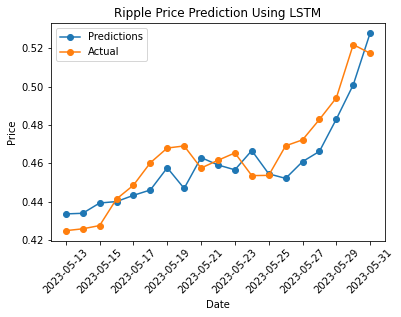

In [45]:
predictions = LSTM_result_df['Predicted_Ripple_Price']
actual_values = LSTM_result_df['Close']

# Plotting the line graph
plt.plot(LSTM_result_df['Date'], predictions, marker='o', label='Predictions')
plt.plot(LSTM_result_df['Date'], actual_values, marker='o', label='Actual')

plt.title('Ripple Price Prediction Using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)

plt.legend()

plt.show()

In [46]:
#Bidirectional Long Short Term Memory
np.random.seed(44) 
tf.random.set_seed(44)

X = merged_df_2[['Lagged_closing_price', 'Lagged_score']].values
y = merged_df_2['Close'].values.reshape(-1, 1)

#Scaling
scaler_X = MinMaxScaler(feature_range=(0, 1))
X = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler_y.fit_transform(y)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

#Building LSTM Model
model = Sequential()

model.add(Bidirectional(LSTM(100, activation='relu'), input_shape=(1, 2))) 
model.add(Dense(1))


#Fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler_y.inverse_transform(train_predict)
y_train = scaler_y.inverse_transform(y_train)
test_predict = scaler_y.inverse_transform(test_predict)
y_test = scaler_y.inverse_transform(y_test)

#Evaluation metrics
rmse_train = sqrt(mean_squared_error(y_train, train_predict))
mae_train = mean_absolute_error(y_train, train_predict)
rmse_test = sqrt(mean_squared_error(y_test, test_predict))
mae_test = mean_absolute_error(y_test, test_predict)
mape_test = calculate_mape(y_test, test_predict)
print(f'Root Mean Squared Error: {rmse_test}')
print(f'Mean Absolute Error: {mae_test}')
print(f'Mean Absolute Percentage Error: {mape_test}')

Epoch 1/100
2/2 [==============================] - 2s 12ms/step - loss: 0.3842
Epoch 2/100
2/2 [==============================] - 0s 0s/step - loss: 0.3681
Epoch 3/100
2/2 [==============================] - 0s 15ms/step - loss: 0.3527
Epoch 4/100
2/2 [==============================] - 0s 4ms/step - loss: 0.3378
Epoch 5/100
2/2 [==============================] - 0s 3ms/step - loss: 0.3235
Epoch 6/100
2/2 [==============================] - 0s 12ms/step - loss: 0.3096
Epoch 7/100
2/2 [==============================] - 0s 0s/step - loss: 0.2962
Epoch 8/100
2/2 [==============================] - 0s 4ms/step - loss: 0.2827
Epoch 9/100
2/2 [==============================] - 0s 10ms/step - loss: 0.2702
Epoch 10/100
2/2 [==============================] - 0s 0s/step - loss: 0.2573
Epoch 11/100
2/2 [==============================] - 0s 5ms/step - loss: 0.2450
Epoch 12/100
2/2 [==============================] - 0s 0s/step - loss: 0.2332
Epoch 13/100
2/2 [==============================] - 0s 956us/

In [47]:
BiLSTM_result_df = pd.DataFrame({
    'Date': merged_df_2['Date'].iloc[len(y_train):].values,
    'Close': y_test.flatten(),
    'Predicted_Ripple_Price': test_predict.flatten()
})

#Adding new columns for the direction of the actual and predicted prices
BiLSTM_result_df['Actual_Direction'] = np.where(BiLSTM_result_df['Close'] > BiLSTM_result_df['Close'].shift(1), 'Up', 'Down')
BiLSTM_result_df['Predicted_Direction'] = np.where(BiLSTM_result_df['Predicted_Ripple_Price'] > BiLSTM_result_df['Predicted_Ripple_Price'].shift(1), 'Up', 'Down')
print(BiLSTM_result_df.head())

#Comparing 'Actual_Direction' and 'Predicted_Direction' columns
matches = BiLSTM_result_df['Actual_Direction'] == BiLSTM_result_df['Predicted_Direction']
accuracy = (matches.sum() / len(matches)) * 100
print(f'Accuracy: {accuracy}%')

        Date     Close  Predicted_Ripple_Price Actual_Direction  \
0 2023-05-13  0.424903                0.436833             Down   
1 2023-05-14  0.425860                0.434781               Up   
2 2023-05-15  0.427562                0.437680               Up   
3 2023-05-16  0.441422                0.438746               Up   
4 2023-05-17  0.448589                0.445701               Up   

  Predicted_Direction  
0                Down  
1                Down  
2                  Up  
3                  Up  
4                  Up  
Accuracy: 52.63157894736842%


In [54]:
#SVR- Support Vector Regression

X = merged_df_2[['Lagged_closing_price']].values
y = merged_df_2['Close'].values.reshape(-1, 1)

scaler_X = MinMaxScaler(feature_range=(0, 1))
X = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = SVR(kernel='rbf', C=1e2, gamma=0.1)

#Fit the model
model.fit(X_train, y_train.ravel())

train_predict = model.predict(X_train).reshape(-1, 1)
test_predict = model.predict(X_test).reshape(-1, 1)

train_predict = scaler_y.inverse_transform(train_predict)
y_train = scaler_y.inverse_transform(y_train)
test_predict = scaler_y.inverse_transform(test_predict)
y_test = scaler_y.inverse_transform(y_test)

#Evaluation metrics
rmse_train = sqrt(mean_squared_error(y_train, train_predict))
mae_train = mean_absolute_error(y_train, train_predict)
rmse_test = sqrt(mean_squared_error(y_test, test_predict))
mae_test = mean_absolute_error(y_test, test_predict)
mape_test = calculate_mape(y_test, test_predict)
print(f'Root Mean Squared Error: {rmse_test}')
print(f'Mean Absolute Error: {mae_test}')
print(f'Mean Absolute Percentage Error: {mape_test}')

Root Mean Squared Error: 0.009853285954029291
Mean Absolute Error: 0.0072448374092937955
Mean Absolute Percentage Error: 1.54%


In [55]:
SVR_result_df = pd.DataFrame({
    'Date': merged_df_2['Date'].iloc[len(y_train):].values,
    'Close': y_test.flatten(),
    'Predicted_Ripple_Price': test_predict.flatten()
})

# Adding new columns for the direction of the actual and predicted prices
SVR_result_df['Actual_Direction'] = np.where(SVR_result_df['Close'] > SVR_result_df['Close'].shift(1), 'Up', 'Down')
SVR_result_df['Predicted_Direction'] = np.where(SVR_result_df['Predicted_Ripple_Price'] > SVR_result_df['Predicted_Ripple_Price'].shift(1), 'Up', 'Down')

print(SVR_result_df.head())

# Compare 'Actual_Direction' and 'Predicted_Direction' columns
matches = SVR_result_df['Actual_Direction'] == SVR_result_df['Predicted_Direction']
accuracy = (matches.sum() / len(matches)) * 100
print(f'Accuracy: {accuracy}%')

        Date     Close  Predicted_Ripple_Price Actual_Direction  \
0 2023-05-13  0.424903                0.434468             Down   
1 2023-05-14  0.425860                0.428800               Up   
2 2023-05-15  0.427562                0.429735               Up   
3 2023-05-16  0.441422                0.431395               Up   
4 2023-05-17  0.448589                0.444831               Up   

  Predicted_Direction  
0                Down  
1                Down  
2                  Up  
3                  Up  
4                  Up  
Accuracy: 68.42105263157895%


In [50]:
SVR_result_df.to_csv("C:/Dissertation/ML Codes Final/ML Output/xrp_no_score.csv")

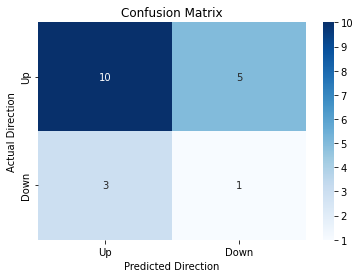

              precision    recall  f1-score   support

          Up       0.77      0.67      0.71        15
        Down       0.17      0.25      0.20         4

    accuracy                           0.58        19
   macro avg       0.47      0.46      0.46        19
weighted avg       0.64      0.58      0.61        19



In [53]:
result= pd.read_csv("C:/Dissertation/ML Codes Final/ML Output/xrp_svr.csv")
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report


report = classification_report(result['Actual_Direction'], result['Predicted_Direction'], labels=['Up', 'Down'])
cm = confusion_matrix(result['Actual_Direction'], result['Predicted_Direction'], labels=['Up', 'Down'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Up', 'Down'], yticklabels=['Up', 'Down'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Direction")
plt.ylabel("Actual Direction")
plt.show()
print(report)